In [1]:
import numpy as np
import pandas as pd
from numpy import pi
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
from qiskit.providers.aer import noise
import random
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [2]:
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_burlington') #ibmq_burlington ibmq_16_melbourne ibmq_ourense
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

c:\users\niels\envs\dev_qiskit\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


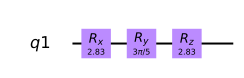

In [3]:
R=[]
n=3
qreg = QuantumRegister(n)
for i in range(3):
    R.append(random.randint(1,10))
qreg_exp = QuantumRegister(1)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.rx(pi/10*R[0],0)
qc_expected.ry(pi/10*R[1],0)
qc_expected.rz(pi/10*R[2],0)
#qc_expected.x(0)
qc_expected.draw(output='mpl')


The expected state is: [0.80432973+0.j         0.59411593+0.00894169j]


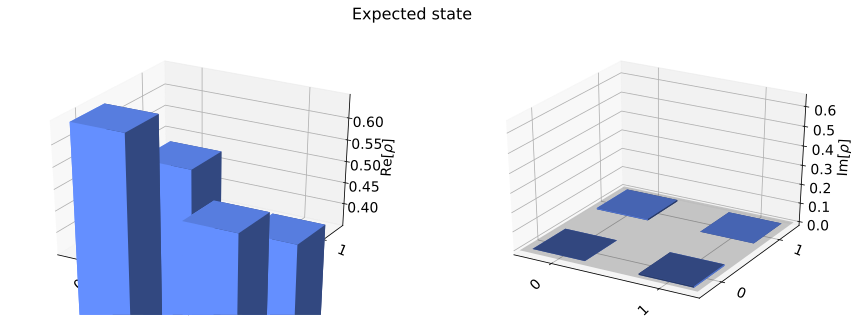

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

[0.80432973+0.j         0.59411593+0.00894169j]


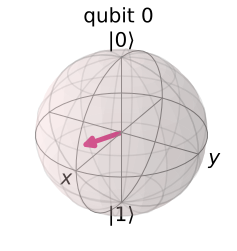

In [5]:
simulatorvec = Aer.get_backend('statevector_simulator')
result = execute(qc_expected, backend = simulatorvec).result()
statevector = result.get_statevector()
print(statevector)
%matplotlib inline
plot_bloch_multivector(statevector)

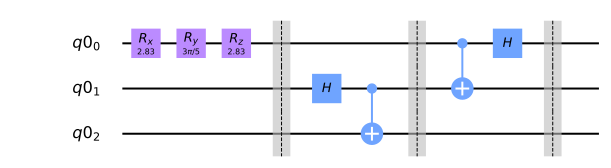

In [6]:
qc1 = QuantumCircuit(qreg)
qc1.rx(pi/10*R[0],0)
qc1.ry(pi/10*R[1],0)
qc1.rz(pi/10*R[2],0)
#qc1.x(0)
qc1.barrier()
qc1.h(1)
qc1.cx(1,2)
qc1.barrier()
qc1.cx(0,1)
qc1.h(0)
qc1.barrier()
qc1.draw(output='mpl')

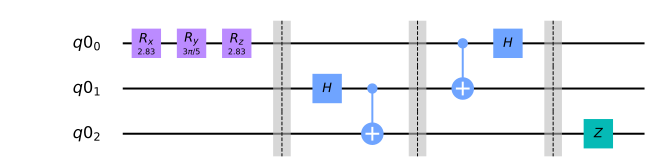

In [7]:
qc2 = QuantumCircuit(qreg)
qc3 = QuantumCircuit(qreg)
qc4 = QuantumCircuit(qreg)
qcs = [qc1, qc2, qc3, qc4]
for qc in range(3):
    q2 = QuantumCircuit(qreg)
    if qc == 0 or qc == 2:
        q2.z(2)
    if qc == 1 or qc == 2:
        q2.x(2)
    qcs[qc+1]= qcs[0] +q2
qcs[1].draw(output='mpl')

In [8]:
#mitigation measurement
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = qc1.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,backend = device,shots = 2000,optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


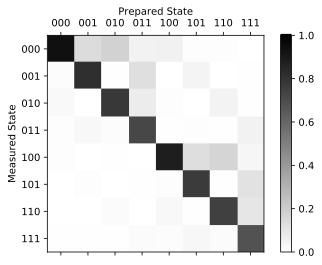

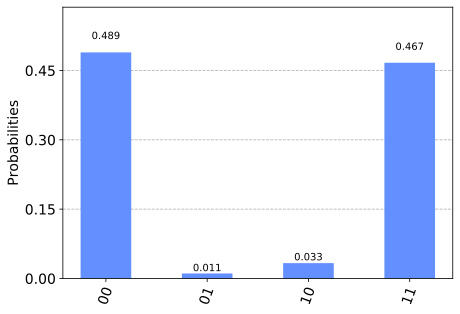

In [9]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
counts =[0,0,0,0,0,0,0,0]
bits = [ '000', '100', '001', '101', '010', '110', '011', '111']
for i in range(0,8):
    counts[i]=calres.get_counts(cal_circuits[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0
countsdev = {'00':counts[0]["000"]+counts[0]["001"]+counts[0]["010"]+counts[0]["011"]+
             counts[1]["000"]+counts[1]["001"]+counts[1]["010"]+counts[1]["011"]+
             counts[2]["000"]+counts[2]["001"]+counts[2]["010"]+counts[2]["011"]+
             counts[3]["000"]+counts[3]["001"]+counts[3]["010"]+counts[3]["011"],
             '01':counts[0]["100"]+counts[0]["101"]+counts[0]["110"]+counts[0]["111"]+
             counts[1]["100"]+counts[1]["101"]+counts[1]["110"]+counts[1]["111"]+
             counts[2]["100"]+counts[2]["101"]+counts[2]["110"]+counts[2]["111"]+
             counts[3]["100"]+counts[3]["101"]+counts[3]["110"]+counts[3]["111"],
             '10':counts[4]["000"]+counts[4]["001"]+counts[4]["010"]+counts[4]["011"]+
             counts[5]["000"]+counts[5]["001"]+counts[5]["010"]+counts[5]["011"]+
             counts[6]["000"]+counts[6]["001"]+counts[6]["010"]+counts[6]["011"]+
             counts[7]["000"]+counts[7]["001"]+counts[7]["010"]+counts[7]["011"],
             '11':counts[4]["100"]+counts[4]["101"]+counts[4]["110"]+counts[4]["111"]+
             counts[5]["100"]+counts[5]["101"]+counts[5]["110"]+counts[5]["111"]+
             counts[6]["100"]+counts[6]["101"]+counts[6]["110"]+counts[6]["111"]+
             counts[7]["100"]+counts[7]["101"]+counts[7]["110"]+counts[7]["111"]}
epsilon01=countsdev["01"]/1600
epsilon10=countsdev["10"]/1600
beta0=(epsilon10-epsilon01)
beta1=1-epsilon10-epsilon01
plot_histogram(countsdev)

In [10]:
backends = [simulator, device,0]
paulis = [('Z','Z','X'),('Z','Z','Y'),('Z','Z','Z')]
basis = ['X','Y','Z']
result =[0,0,0,0]
x=0
for be in backends:
    state = {'X': {'0': 0, '1': 0}, 'Y': {'0': 0, '1': 0}, 'Z': {'0': 0, '1': 0}}
    z=0
    for qc in qcs:
        qst_circuit = state_tomography_circuits(qc,qreg)
        if be == simulator:
            job = qiskit.execute(qst_circuit, be, shots=1000,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        if be == device:
            job = qiskit.execute(qst_circuit, be, shots=1000)
            job_monitor(job)
            result[x] = job.result()
            x=x+1
        if be == 0:
            tom = StateTomographyFitter(meas_filter.apply(result[x]),qst_circuit)
            x=x+1
        else:
            tom = StateTomographyFitter(job.result(), qst_circuit)
        for pauli in paulis:
            for bit in bits:
                if bit not in tom.data[pauli]:
                    tom.data[pauli][bit]=0
        y=0
        for bas in basis:
            state.update({bas: {'0': state[bas]['0']+tom.data[(paulis[y])][bits[2*z]],
                                '1': state[bas]['1']+tom.data[(paulis[y])][bits[2*z+1]]}})
            y=y+1
        z=z+1
    if be == simulator:
        state_sim = state
        print('The full state for simulator is', state)
    if be == device:
        state_dev = state
        print('The full state for device is', state)
        x=0
    if be == 0:
        state_err = state
        print('The corrected state for device is', state)

The full state for simulator is {'X': {'0': 909, '1': 123}, 'Y': {'0': 507, '1': 454}, 'Z': {'0': 635, '1': 364}}
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
The full state for device is {'X': {'0': 725, '1': 299}, 'Y': {'0': 509, '1': 450}, 'Z': {'0': 645, '1': 360}}
The corrected state for device is {'X': {'0': 754.2801719910657, '1': 271.43588023639785}, 'Y': {'0': 451.0272817721185, '1': 486.1984675888601}, 'Z': {'0': 650.0800971597323, '1': 358.00406225855653}}


In [12]:
print(state_dev)
new_dev=((state_dev['Z']['0']-state_dev['Z']['1'])/(state_dev['Z']['0']+state_dev['Z']['1'])-beta0)/beta1
newstate_dev={'X': {'0': state_dev['X']['0'], '1': state_dev['X']['1']}, 'Y': {'0': state_dev['Y']['0'], '1': state_dev['Y']['1']}, 'Z': {'0': 0, '1': 0}}
newstate_dev['Z']['0']=((new_dev+1)/2)*state_dev['Z']['0']
newstate_dev['Z']['1']=(1-(new_dev+1)/2)*state_dev['Z']['1']
print(newstate_dev)
print(state_dev)

{'X': {'0': 725, '1': 299}, 'Y': {'0': 509, '1': 450}, 'Z': {'0': 645, '1': 360}}
{'X': {'0': 725, '1': 299}, 'Y': {'0': 509, '1': 450}, 'Z': {'0': 357.0339577281378, '1': 160.72523289592309}}
{'X': {'0': 725, '1': 299}, 'Y': {'0': 509, '1': 450}, 'Z': {'0': 645, '1': 360}}


In [13]:
# fidelity processing for sim and dev

Iden = np.matrix('1,0;0,1')
XPaul = np.matrix('0,1;1,0')
YPaul = np.matrix('0,0-1j;0+1j,0')
ZPaul = np.matrix('1,0;0,-1')

# simulator Bloch vector
state_tot=[state_sim,state_dev,state_err,newstate_dev]
r_sim=[0,0,0,0]
rho=[0,0,0,0]
t=0
for stat in state_tot:
    r=0
    for bas in basis:
        r_sim[r] = (stat[bas]['0']*1 + stat[bas]['1']*(-1)) / (stat[bas]['0'] + stat[bas]['1'])
        r=r+1
    rho[t] = (1/2)*(Iden+r_sim[0]*XPaul+r_sim[1]*YPaul+r_sim[2]*ZPaul)
    t=t+1

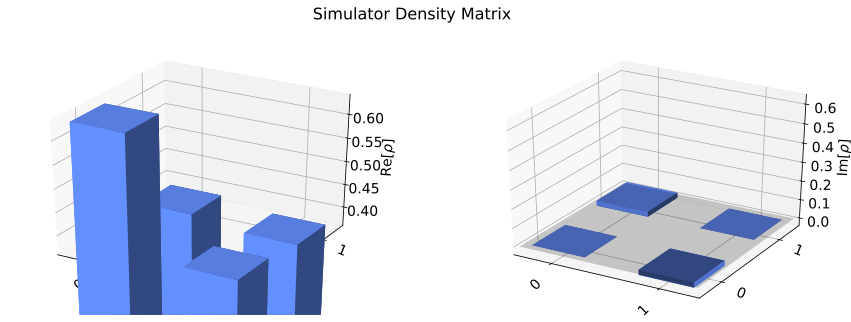

In [14]:
# these plots look a little funny for secret_h at least
plot_state_city(rho[0], title='Simulator Density Matrix')

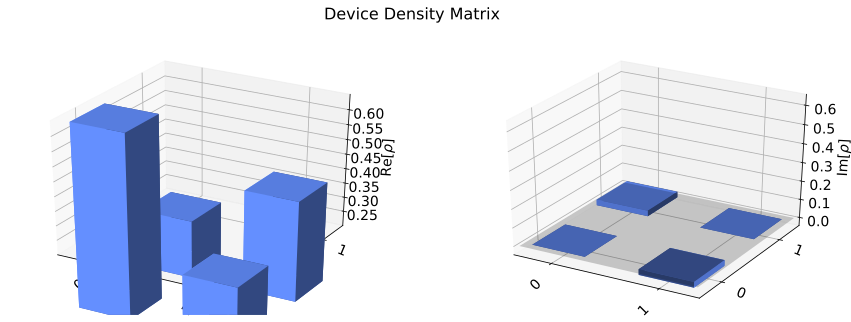

In [15]:
plot_state_city(rho[1] , title='Device Density Matrix')

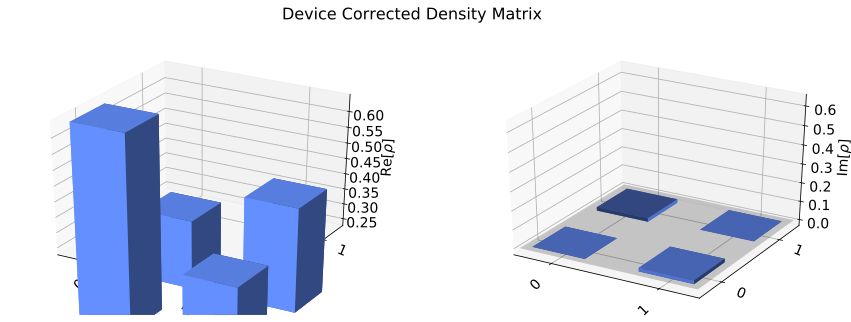

In [16]:
plot_state_city(rho[2], title='Device Corrected Density Matrix')

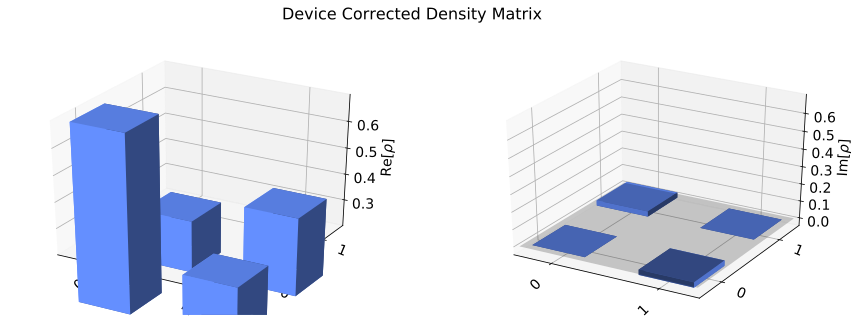

In [17]:
plot_state_city(rho[3], title='Device Corrected Density Matrix')

In [18]:
Sim_Fidelity = state_fidelity(psi_expected, rho[0], validate=False)
Dev_Fidelity = state_fidelity(psi_expected, rho[1], validate=False)
Err_Fidelity = state_fidelity(psi_expected, rho[2], validate=False)
Err2_Fidelity = state_fidelity(psi_expected, rho[3], validate=False)
print('Simulator Fidelity:', Sim_Fidelity)
print('Device Fidelity:', Dev_Fidelity)
print('Corrected Device Fidelity:', Err_Fidelity)
print('Corrected Device Fidelity:', Err2_Fidelity)

Simulator Fidelity: 0.9042143589867818
Device Fidelity: 0.7409131646074602
Corrected Device Fidelity: 0.7672550352420003
Corrected Device Fidelity: 0.7549566097030949


In [19]:
# checking validity of the density matrices, little problem with the simulator one...
rho_dev = DensityMatrix(rho[0])
rho_sim = DensityMatrix(rho[2])

In [20]:
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

Is the simulator density matrix valid? True
Is the device density matrix valid? True


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table